In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt
import random

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[-2]).unwrapped
discrete_actions = False

import gc


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Creature(nn.Module):
    def __init__(self):
        super(Creature, self).__init__()
    
        self.layer1 = nn.Linear(env.observation_space.shape[0], 20)
        self.layer2 = nn.Linear(20, 20)
        
        if discrete_actions:
            self.layer3 = nn.Linear(20, env.action_space.n)
        else:
            self.layer3 = nn.Linear(20, env.action_space.shape[0])
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
input_num = (len(get_params(Creature()))*2)
output_num = len(get_params(Creature()))

mem_length = 10
num_mems = 5

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d(input_num, 128, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        
        self.layer5 = nn.Linear(16*13, output_num)
        
    def forward(self, mom,dad,a):
        out = torch.cat([mom,dad]).unsqueeze(0)
        out = out.unsqueeze(-1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        out = self.layer5(out)
        if a >= 0:
            z = torch.zeros(mom.shape).to(device)
            mom_func = (mom+(torch.tanh(out+3)*a)) * (torch.min(mom,z)/(mom+0.000001))
            dad_func = (dad+(torch.tanh(-out+3)*a)) * (torch.max(dad,z)/(dad+0.000001))
            out = mom_func + dad_func
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 8, 5, stride=1, padding=0),  
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer4 = nn.Linear(16*987, 128)
        self.layer5 = nn.Linear(128, mem_length)
        self.layer6 = nn.Sequential(       
            nn.Linear(mem_length, 1))#,
            #nn.Sigmoid())
    def forward(self, out,r):
        out = torch.cat([out,r],-1)
        out = out.unsqueeze(1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        
        out = self.layer4(out)
        out = self.layer5(out)
        out = out * r
        out = self.layer6(out)
        return out

all_a = 0

class ReadHead(nn.Module):
    def __init__(self):
        super(ReadHead, self).__init__()
        self.layer1 = nn.Linear(output_num, 128)
        self.layer2 = nn.Linear(128, num_mems)
    def forward(self, out):
        out = self.layer1(out)
        out = self.layer2(out)
        return torch.tanh(out)
    
class WriteHead(nn.Module):
    def __init__(self):
        super(WriteHead, self).__init__()
        self.layer1 = nn.Linear(output_num+(num_mems*mem_length), 128)
        self.layer2 = nn.Linear(128, num_mems+mem_length+mem_length)
    def forward(self, out,mem_flat):
        mem_flat = mem_flat.unsqueeze(0).repeat(out.size(0),1)
        

        out = torch.cat([out,mem_flat],-1)
        out = self.layer1(out)
        out = self.layer2(out)
        
        w = out[...,0:num_mems]
        e = out[...,num_mems:num_mems+mem_length]
        a = out[...,num_mems+mem_length:]
        #w,e,a = torch.unbind(out,1)
        return w,torch.sigmoid(e),torch.tanh(a)
    






In [3]:
def mate(m,d,mutation_rate_m,mutation_rate_d,use_gen,mutation_scale=0.07):
    child = Creature()
    #mom = mutate(mom,mutation_rate_m,mutation_scale)
    #dad = mutate(dad,mutation_rate_d,mutation_scale)
    
    #get parents as vectors
    mom = get_params(m)
    dad = get_params(d)
    
    a = np.array([all_a])
    a = torch.from_numpy(a).type("torch.FloatTensor").to(device)

    generated = use_gen(mom,dad,a).squeeze(0)
    child = set_params(child,generated)
    
    #mutate child
    mutation_rate = np.min([mutation_rate_m,mutation_rate_d])
    child = mutate(child,mutation_rate,mutation_scale)
    
    return child

def mutate(creature,mutation_rate=0.2,scale = 0.07,start_layer = 0):
    if mutation_rate != 0:
        new = creature.__class__().to(device)
        new.load_state_dict(creature.state_dict()) 
        for idx,p in enumerate(new.parameters()):
            if idx < start_layer:
                continue
            mutation = np.random.normal(scale = scale,size = p.data.shape)
            mutation *= np.random.choice([1, 0], p.data.shape,p=[mutation_rate,1-mutation_rate])
            mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)
            p.data += mutation
        return new
    else:
        return creature

def evolve(population,out_size,use_gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    pick_probabilities = get_pick_probabilities(p_fitness)
    choice = np.random.choice(pick_probabilities.size,out_size+1, p = pick_probabilities)
    
    #mate and mutate creatures
    new_population = []
    for p in range(out_size):
        first_choice = population[choice[p]]
        #no incest
        second_choice = choice[np.where(choice!=choice[p])]
        if second_choice.size >len(population)/2:#!=0:
            second_choice = second_choice[random.randint(0,second_choice.size-1)]
            second_choice = population[second_choice]
        else:
            second_choice = population[choice[p+1]]
        
        par_fit = np.max([p_fitness[choice[p]],p_fitness[choice[p+1]]])
        
        child = mate(first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],use_gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    
    return new_population



In [4]:
def gen_children(population,use_gen,batch_size, a = 0.1):
    mom = []
    dad = []
    child = []
    for b in range(batch_size):
        m = get_params(random.choice(population))
        d = get_params(random.choice(population))

        a = np.array([a])
        a = torch.from_numpy(a).type("torch.FloatTensor").to(device)


        c = use_gen(m,d,a).squeeze(0)

        mom.append(m)
        dad.append(d)
        child.append(c)

    mom = torch.stack(mom).to(device)
    dad = torch.stack(dad).to(device)
    child = torch.stack(child).to(device)
    return child    
        
def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    
    
    gen_loss_all = []
    dis_loss_all = []
    rec_loss_all = []
    for e in range(n_epochs):
        
        #shuffle arrays in unison
        #ind = np.arange(len(population))
        #np.random.shuffle(ind)
        #population = np.array(population)[ind]
        #p_fitness = p_fitness[ind]
        
        for i in range(len(population)//batch_size):

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            read_optimizer.zero_grad()
            
            real_batch = []
            #turn population into vectors
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            real_read = read_head(real_batch)
            real_read = read(memory.unsqueeze(0),real_read).squeeze(0)
            
            #train discriminator on population
            dis_out_r = dis(real_batch,real_read.squeeze(1)).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r,rank))
            dis_error_real.backward()

            #generate children from population
            child = gen_children(population,gen,batch_size,a = all_a)
            fake_read = read_head(child)
            fake_read = read(memory.unsqueeze(0),fake_read).squeeze(0)
            dis_out_f = dis(child,fake_read.squeeze(1)).squeeze(-1)
            
            
            
            #train discriminator on generator output
            #if torch.max(dis_out_f)>torch.min(p_fitness):
            dis_error_fake = torch.mean(dis_out_f)                 
            dis_error_fake.backward(retain_graph=True)
            dis_optimizer.step() 
            read_optimizer.step() 
            
            
            #train generator
            gen_error = -torch.mean(dis_out_f)
            total_gen_error = gen_error 
            total_gen_error.backward()
            gen_optimizer.step()
            
            
        #keep losses to draw graph    
        gen_loss_all.append(gen_error)
        dis_loss_all.append(dis_error_fake)
        rec_loss_all.append(dis_error_real)    
        #if e %  5 == 0:    
        #print("Discriminator loss real : {}".format(dis_error_real))
        #print("Discriminator loss generated : {}".format(dis_error_fake))
        #print("Generator loss : {}".format(gen_error))
        #print("Child error : {}".format(child_error*0.1))
        #print("")
    return gen_loss_all, dis_loss_all, rec_loss_all

def train_write(population,p_fitness,batch_size,n_epochs = 25):
    temp_mem = memory.repeat(batch_size,1,1)
    pf = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    total_write_loss = []
    for e in range(n_epochs):
        write_optimizer.zero_grad()

        real_batch = []
        #turn population into vectors
        for b in range(batch_size):
            real_batch.append(get_params(population[b]).unsqueeze(0))
        real_batch = torch.cat(real_batch, dim=0).to(device)
        
        w,e,a = write_head(real_batch,memory.contiguous().view(memory.numel()))

        
        mem = write(temp_mem,w,e,a)
        dis_out = []
        for idx,m in enumerate(mem):
            real_read = read_head(real_batch[idx]).unsqueeze(0)
            real_read = read(m.unsqueeze(0),real_read).squeeze(0)
            d = dis(real_batch[idx].unsqueeze(0),real_read).squeeze(-1)
            dis_out.append(d)
            
        dis_out = torch.stack(dis_out).squeeze(1)
       
        write_loss = nn.MSELoss()(dis_out,pf)
        #print("#")
        #print(dis_out)
        #print(pf)
        #print("#")
        #write_loss = torch.mean(dis_out)
        write_loss.backward()

        write_optimizer.step()

        total_write_loss.append(write_loss)
    return total_write_loss

def write_to_memory(memory,batch_size):
    #write to memory
    real_batch = []
    for b in range(batch_size):
        real_batch.append(get_params(population[b]).unsqueeze(0))
    real_batch = torch.cat(real_batch, dim=0).to(device)
    w,e,a = write_head(real_batch,memory.contiguous().view(memory.numel()))
    yeet = memory.unsqueeze(0)
    for b in range(batch_size):
        
        yeet = write(yeet,w[b].unsqueeze(0),e[b].unsqueeze(0),a[b].unsqueeze(0))#.squeeze(0)
    return  yeet.squeeze(0).detach()

starting training
1004
population fitness : [-111.56711396  -96.45389208]
mean fit : -104.01050301774653
Mutation rate : [0.4 0. ]


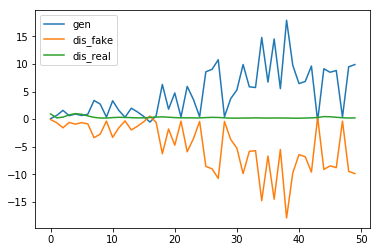

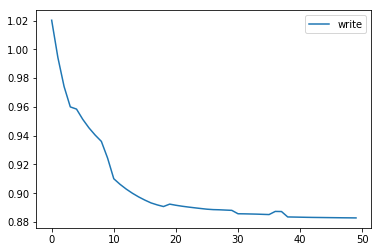

tensor([[ 1.0449,  0.1826,  1.4826,  1.3390,  1.4260,  1.4824,  0.0824,  1.3142,
          0.1812,  1.4825],
        [ 1.0546,  0.9371,  1.1141,  1.0942,  1.0681,  1.1141,  0.7788,  0.9455,
          0.9368,  1.1138],
        [ 1.3910,  1.2611,  1.4776,  1.4461,  1.1482,  1.4778,  0.1012,  0.2319,
          1.2600,  1.4750],
        [ 1.2679,  0.4669,  1.8083,  1.6284,  1.4689,  1.8082, -0.2880,  0.5631,
          0.4645,  1.8060],
        [ 1.0546,  0.9371,  1.1141,  1.0942,  1.0681,  1.1141,  0.7788,  0.9455,
          0.9368,  1.1138]], device='cuda:0')
Generation 1  fitness : 0.9999999999616646
#################################
population fitness : [-16.29799297 -96.41222935 -96.24989874 -96.3547644 ]
mean fit : -76.32872136571183
Mutation rate : [0.         0.20027473 0.19986893 0.20013107]


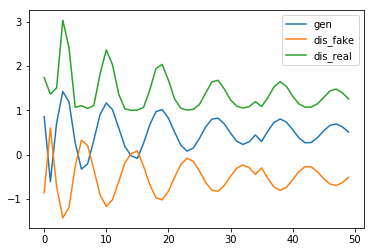

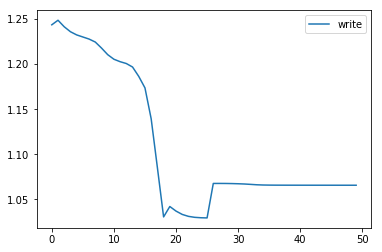

tensor([[ 1.5094,  0.6471,  1.9471,  1.8035,  1.8898,  1.9468, -0.3394,  0.4124,
         -0.2833,  1.9463],
        [ 1.4645,  1.3470,  1.5240,  1.5041,  1.4775,  1.5240,  0.1542,  0.2624,
          0.5266,  1.5233],
        [ 1.8349,  1.7050,  1.9214,  1.8900,  1.5915,  1.9216, -0.3121, -0.2305,
          0.8158,  1.9182],
        [ 3.5397,  2.7387,  4.0801,  3.9002,  3.7359,  4.0798, -0.9754, -0.9458,
         -1.8065,  4.0727],
        [ 1.4645,  1.3470,  1.5240,  1.5041,  1.4775,  1.5240,  0.1542,  0.2624,
          0.5266,  1.5233]], device='cuda:0')
Generation 2  fitness : 1.7320508075572114
#################################
population fitness : [-96.20254899 -96.83156465 -96.47183517 -96.65909905 -96.40715695
 -96.25296943]
mean fit : -96.4708623729848
Mutation rate : [0.         0.53093347 0.22729648 0.38536037 0.17270352 0.0425584 ]


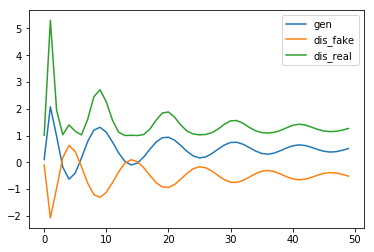

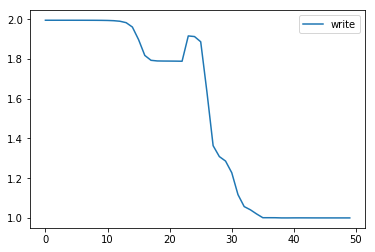

tensor([[ 1.9670,  1.1443,  1.5629,  1.3062,  0.7196,  2.4427,  0.1580, -0.1596,
          0.2140,  1.5626],
        [ 1.8823,  1.8010,  1.3262,  1.0501,  0.5451,  1.9770,  0.6080, -0.2127,
          0.9806,  1.3259],
        [ 2.2785,  2.1870,  1.5568,  1.4079,  0.5678,  2.4023,  0.1700, -0.5345,
          1.2978,  1.5550],
        [ 5.5446,  4.9171,  1.2041,  1.7218, -0.6840,  6.2448,  1.2032, -0.9964,
          0.3719,  1.2038],
        [ 3.6624,  3.7353,  1.0234, -0.8841, -0.8825,  3.9044,  2.5383, -0.9401,
          2.9148,  1.0236]], device='cuda:0')
Generation 3  fitness : 1.4883398831693233
#################################
population fitness : [  -2.04812594  -96.37807832  -96.46012364  -97.73757775  -93.73756978
  -94.14115534  -93.90783011 -118.80564633]
mean fit : -86.6520134004776
Mutation rate : [0.         0.20239984 0.20257588 0.20531686 0.19673421 0.19760016
 0.19709953 0.25052173]


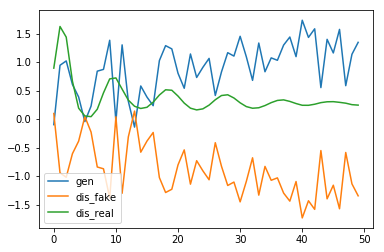

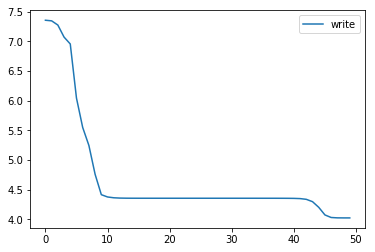

tensor([[ 0.1616,  2.0281,  0.0034,  0.4203, -0.3268,  0.3478,  0.6703, -0.6710,
          1.0977,  0.0032],
        [ 0.0944,  2.7109, -0.1167,  0.1387, -0.4133,  0.1304,  0.8512, -0.7011,
          1.8904, -0.1169],
        [ 0.2241,  3.1122, -0.0454,  0.4802, -0.4146,  0.2703,  0.6901, -0.8262,
          2.2230, -0.0460],
        [-0.7705,  7.6495, -0.9227, -1.0144, -0.9889, -0.7460,  1.0071, -0.9999,
          3.1043, -0.9227],
        [-0.7849,  6.2840, -0.9067, -3.4191, -0.9946, -0.7738,  1.0710, -0.9972,
          5.4636, -0.9067]], device='cuda:0')
Generation 4  fitness : 2.6432216946123703
#################################
population fitness : [-119.36824098   -4.29972933 -119.12520347   -1.59849842 -119.37763699
 -117.55804787  -93.43915297   -1.59756407 -118.98486011 -119.34394611]
mean fit : -81.46928803303005
Mutation rate : [2.01880090e-01 4.63199652e-03 2.01463480e-01 1.60163635e-06
 2.01896196e-01 1.98777094e-01 1.57432977e-01 0.00000000e+00
 2.01222906e-01 2.01838444e-

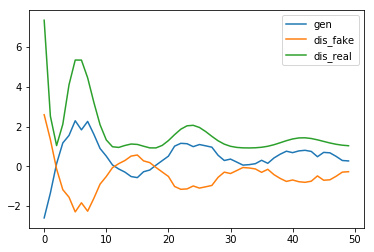

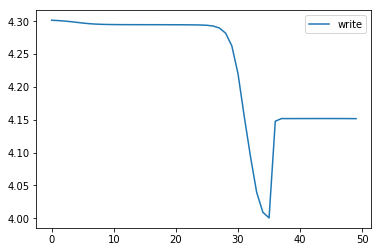

tensor([[-0.8988,  1.0818, -0.9126, -0.8763, -0.9414, -0.8826,  0.9756, -0.9713,
          1.0085, -0.9126],
        [-0.8777,  1.1838, -0.9013, -0.8728, -0.9344, -0.8737,  0.9878, -0.9666,
          1.0995, -0.9013],
        [-0.8670,  1.2219, -0.8963, -0.8392, -0.9364, -0.8620,  0.9706, -0.9811,
          1.1328, -0.8964],
        [-0.9750,  1.7181, -0.9916, -1.0016, -0.9988, -0.9723,  1.0054, -1.0000,
          1.2296, -0.9916],
        [-0.9751,  1.6036, -0.9892, -1.2797, -0.9994, -0.9738,  1.0129, -0.9997,
          1.5161, -0.9892]], device='cuda:0')
Generation 5  fitness : 1.55996211131216
#################################
population fitness : [  -2.84645153 -119.03405268 -117.46822307   -3.01517747 -119.2851336
 -117.40657912 -117.14137193 -117.25436924   -3.80829089 -119.23022061
   -1.88537205 -118.01856898]
mean fit : -79.69948426347493


In [ ]:
#randomly inititialise starting population
population_size = 2
max_population = 20

batch_size = population_size
out_size = population_size
population = []

for p in range(population_size):
    population.append(Creature().to(device))

gen = Generator().to(device)
dis = Discriminator().to(device)

read_head = ReadHead().to(device)
write_head = WriteHead().to(device)
read_optimizer = torch.optim.Adam(read_head.parameters(), lr=0.001,betas=(0.9,0.999))
write_optimizer = torch.optim.Adam(write_head.parameters(), lr=0.001,betas=(0.9,0.999))


lr = 0.0001
epsilon = 0.000001
print("starting training")
print(len(get_params(Creature())))
n_generations = 300000

memory = torch.ones([num_mems,mem_length],requires_grad=False).to(device)
def write(memory,w_,e,a):
    w = w_.squeeze(0).unsqueeze(-1)*torch.ones([1,mem_length]).type("torch.FloatTensor").to(device).unsqueeze(0)
    w = F.cosine_similarity(w.transpose(1,2),memory.transpose(1,2))
    #print(w.shape)
    w = torch.softmax(w,-1)
    erase = (w.unsqueeze(1)*e.unsqueeze(2))
    add = (w.unsqueeze(1)*a.unsqueeze(2))
    return ((memory.transpose(1,2)*(1-erase))+add).transpose(1,2)
def read(memory,w_):
    w = w_.squeeze(0).unsqueeze(-1)*torch.ones([1,mem_length]).type("torch.FloatTensor").to(device).unsqueeze(0)
    w = F.cosine_similarity(w.transpose(1,2),memory.transpose(1,2))
    w = torch.softmax(w,-1)
    batch = []
   
    for b in w:
        batch.append(torch.matmul(memory.transpose(1,2),b))
    return torch.stack(batch)#.squeeze().unsqueeze(0)

for i in range(n_generations):
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.9,0.999))
    
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-100,
                                                             max_steps = 1000)
    
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))
    
    #normalise population fitness
    centered = (p_fitness_-np.min(p_fitness_))**2
    p_fitness = ((centered - np.mean(centered))/np.sqrt(np.var(centered)+epsilon))
    
    write_loss = train_write(population,p_fitness,batch_size = batch_size,n_epochs = 50)
    #write_loss = 0
    memory = write_to_memory(memory,batch_size)
    
    #Train GAN
    gen_loss, dis_loss,rec_loss = train_gan(population,p_fitness,
              batch_size =batch_size,n_epochs = 50)
    
    
        
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,min_reward=-100,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0.4
    
    #Calculate rate at which weights are mutated based on relative fitness
    centered = (-p_fitness_-np.min(-p_fitness_))
    mutation_rate = (centered/np.median(centered))*0.2
    mutation_rate = np.clip(mutation_rate,0,1)
    print("Mutation rate : {}".format(mutation_rate))
    
    #progressively grow population at start
    if out_size < max_population:
        out_size+=2
        batch_size = out_size
    
    #mate and mutate population
    population = evolve(population,out_size,gen,p_fitness,
                                        mutation_rate,mutation_scale)
    
    #yeet = 0
    #for obj in gc.get_objects():
    #    if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
    #        yeet  += 1
    #print(yeet)
            #print(type(obj), obj.size())
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_fake')
    plt.plot(rec_loss,label='dis_real')
    plt.legend()
    plt.show()
    plt.plot(write_loss,label='write')
    plt.legend()
    plt.show()
    print(memory)
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness)))
    print("#################################")


In [ ]:
env = gym.make(envs[-2]).unwrapped

p_fitness = measure_population_fitness(population,env,device,discrete_actions,min_reward=-100,
                                                             max_steps = 200)

fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,min_reward=-100,
                                  render = True,max_steps = 5000000)

In [ ]:
X = torch.randn(5).unsqueeze(0)
print(X)
X = X.repeat(10,1)
print(X.shape)